# 1. Dataset generation

In [67]:
import requests
import csv

#Define the query 
pdb_query = '''{"query":{"type":"group","logical_operator":"and","nodes":[{"type":"group","logical_operator":"and","nodes":[{"type":"terminal","service":"text","parameters":{"attribute":"rcsb_polymer_entity_annotation.annotation_id","operator":"exact_match","negation":false,"value":"PF00014"}},{"type":"terminal","service":"text","parameters":{"attribute":"rcsb_polymer_entity_annotation.type","operator":"exact_match","value":"Pfam","negation":false}}],"label":"nested-attribute"},{"type":"terminal","service":"text","parameters":{"attribute":"rcsb_entry_info.diffrn_resolution_high.value","operator":"less_or_equal","negation":false,"value":3}},{"type":"terminal","service":"text","parameters":{"attribute":"entity_poly.rcsb_sample_sequence_length","operator":"range","negation":false,"value":{"from":50,"to":80,"include_lower":true,"include_upper":true}}},{"type":"terminal","service":"text","parameters":{"attribute":"entity_poly.rcsb_mutation_count","operator":"equals","negation":false,"value":0}}],"label":"text"},"return_type":"polymer_entity","request_options":{"group_by_return_type":"representatives","group_by":{"aggregation_method":"sequence_identity","ranking_criteria_type":{"sort_by":"rcsb_entry_info.resolution_combined","direction":"asc"},"similarity_cutoff":50},"paginate":{"start":0,"rows":25},"results_content_type":["experimental"],"sort":[{"sort_by":"score","direction":"desc"}],"scoring_strategy":"combined"}}'''
pdb_url = 'http://search.rcsb.org/rcsbsearch/v2/query?json=%s' % requests.utils.requote_uri(pdb_query)

#Perform the PDB search
req = requests.get(pdb_url)
pdb_dict = req.json()
list_ids = [name['identifier'] for name in pdb_dict['result_set']] #Extract PDB IDs from the results

#Write PDB sequences and details to files
with open('input_msa.txt', 'w') as input_msa, open('pdb_bpti.fasta', 'w') as pdb_btpi, open('polymer_entities.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Identifier', 'Sequence', 'Auth Asym ID', 'Entry ID (Polymer Entity Identifiers)'])
    print("Downloading PDB sequences and details...")
    
    for protein_id in list_ids:
        results = []
        entry_id, chain_id = protein_id.split("_")  #Split PDB ID into entry and chain
        req2 = requests.get('https://data.rcsb.org/rest/v1/core/polymer_entity/%s/%s' % (entry_id, chain_id))
        data = req2.json()

        #Extract sequence and chain 
        sequence = data['entity_poly']['pdbx_seq_one_letter_code']
        chain = data['rcsb_polymer_entity_container_identifiers']['auth_asym_ids'][0]

        #Write details to CSV file
        results.append(protein_id)
        results.append(sequence)
        results.append(chain)
        results.append(entry_id)
        writer.writerow(results)

        #Write sequence to FASTA file
        input_msa.write(entry_id + ':' + chain + '\n')
        pdb_btpi.write('>' + entry_id + '_' + chain + '\n' + sequence + '\n')

print("Successfully created input_msa.txt, pdb_bpti.fasta and polymer_entities.csv")


Successfully created input_msa.txt, pdb_bpti.fasta and polymer_entities.csv


# 2. Creation of Hidden Markov Model (HMM build)

In [68]:
#Transform the multiple sequence alignment form FASTA format to Stockholm

from Bio import SeqIO

records = SeqIO.parse("cut_kunitz_3d.aln", "fasta")
count = SeqIO.write(records, "cut_kunitz.stockholm", "stockholm")
print("Converted %s records" %count)

Converted 21 records


In [69]:
#Create the HMM from the MSA and save it into a file called kunitz.hmm

import pyhmmer

msa_file_path = "cut_kunitz.stockholm"
alphabet = pyhmmer.easel.Alphabet.amino()

with pyhmmer.easel.MSAFile(msa_file_path, digital=True, alphabet=alphabet) as msa_file:
    msa = msa_file.read()
    
msa.name = b"kunitz domain"

builder = pyhmmer.plan7.Builder(alphabet)
background = pyhmmer.plan7.Background(alphabet)
kunitz_hmm, _, _ = builder.build_msa(msa, background) #Build a new HMM from msa using the builder configuration.

print(kunitz_hmm.consensus)

#Save the HMM
with open("kunitz.hmm", "wb") as output_file:
    kunitz_hmm.write(output_file)

erpsfcllpadtgpcralikrfYYnakekkCerFvYgGCgGNeNnFeteeeCrrtClgv


In [70]:
def iter_target_match(alignment):
    position = alignment.hmm_from
    for hmm_letter, amino_acid in zip(alignment.hmm_sequence, alignment.target_sequence):
        if hmm_letter != ".":
            yield position, amino_acid
            position += 1

# 3. Download positive and negative benchmark sets

In [71]:
### POSITIVE SET ###
pos_uniprot_query = "((xref:pfam-PF00014) AND (reviewed:true))"
pos_uniprot_url = f"https://rest.uniprot.org/uniprotkb/stream?format=fasta&query={requests.utils.requote_uri(pos_uniprot_query)}"
pos_req = requests.get(pos_uniprot_url)

if pos_req.status_code == 200:
    pos_ids = set()

    with open("all_pos.fasta", "w") as pos_fasta:
        print("Downloading positive set...")
        for line in pos_req.iter_lines():
            line = line.decode("utf-8")  #Decode bytes to string
            if line.startswith(">"):
                pos_fasta.write(line + "\n")                #Write the header line to the FASTA file
                pos_id = line.split()[0][1:]                #Extract the ID from the header line and add it to the set
                pos_ids.add(pos_id)
            else:
                pos_fasta.write(line + "\n")                #Write sequence lines to the FASTA file


    #Write the positive IDs to the file
    with open("all_pos.ids", "w") as pos_ids_file:
        for pos_id in pos_ids:
            pos_ids_file.write(pos_id + "\n")

    print("Positive set downloaded successfully.")
else:
    print("Failed to download the positive set. Status code:", pos_req.status_code)

Positive set downloaded successfully.


In [72]:
### NEGATIVE SET ###
neg_uniprot_query = "((NOT (xref:pfam-PF00014)) AND (reviewed:true))"
neg_uniprot_url = f"https://rest.uniprot.org/uniprotkb/stream?format=fasta&query={requests.utils.requote_uri(neg_uniprot_query)}"
neg_req = requests.get(neg_uniprot_url)

if neg_req.status_code == 200:
    neg_ids = set()

    with open("all_neg.fasta", "w") as neg_fasta:
        print("Downloading negative set...")
        for line in neg_req.iter_lines():
            line = line.decode("utf-8")  
            if line.startswith(">"):
                neg_fasta.write(line + "\n")
                neg_id = line.split()[0][1:]
                neg_ids.add(neg_id)
            else:
                neg_fasta.write(line + "\n")

    with open("all_neg.ids", "w") as neg_ids_file:
        for neg_id in neg_ids:
            neg_ids_file.write(neg_id + "\n")

    print("Negative set downloaded successfully.")
else:
    print("Failed to download the negative set. Status code:", neg_req.status_code)

Negative set downloaded successfully.


# 4. BLAST search to refine the positive benchmark set

In [73]:
import subprocess

makeblastdb_cmd = "makeblastdb -in pdb_bpti.fasta -dbtype prot"
blastp_cmd = "blastp -query all_pos.fasta -db pdb_bpti.fasta -out all_pos.blast -outfmt 7"

try:
    subprocess.run(makeblastdb_cmd, shell=True, check=True)
    subprocess.run(blastp_cmd, shell=True, check=True)
    print("BLAST search completed successfully.")
except subprocess.CalledProcessError as err:
    print("Error executing command:", err)




Building a new DB, current time: 05/19/2024 17:09:27
New DB name:   /Users/francescocasini/Desktop/Progetto_da_consegnare/pdb_bpti.fasta
New DB title:  pdb_bpti.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /Users/francescocasini/Desktop/Progetto_da_consegnare/pdb_bpti.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 21 sequences in 0.00412202 seconds.




FASTA-Reader: Ignoring invalid residues at position(s): On line 6: 1, 5
FASTA-Reader: Ignoring invalid residues at position(s): On line 26: 1, 5


BLAST search completed successfully.


In [74]:
selected_ids = set() 

with open('all_pos.blast', "r") as file:
    for line in file:
        if line.startswith("# Fields:"):
            break

    for line in file:
        if line.startswith("#"):
            continue
        
        fields = line.strip().split("\t")
        query_acc_ver = fields[0]
        percent_identity = float(fields[2])
        alignment_length = int(fields[3])
        
        if percent_identity > 95 and alignment_length > 50:
            selected_ids.add(query_acc_ver)  

sorted_ids = sorted(selected_ids)
selected_ids = pos_ids- selected_ids

with open('selected_ids.txt', 'w') as file:
    for protein_id in selected_ids:
        if '|' in protein_id:
            protein_id = protein_id.split('|')[1]
        file.write(protein_id + '\n')



In [75]:
with open('bpti_pos_selected.fasta', 'w') as output_file:
    with open('all_pos.fasta', 'r') as fasta_file:
        capture_sequence = False
        for line in fasta_file:
            if line.startswith(">"):
                sequence_id = line.split()[0][1:]
                if sequence_id in selected_ids:
                    capture_sequence = True
                    output_file.write(line)
                else:
                    capture_sequence = False
            elif capture_sequence:
                output_file.write(line)

# 5. Shuffle and split the sets

In [76]:
import pandas as pd

def fasta_to_dataframe(fasta_file):
    headers = []
    sequences = []
    with open(fasta_file, 'r') as file:
        header = ''
        sequence = ''
        for line in file:
            if line.startswith('>'):
                if header:
                    headers.append(header)
                    sequences.append(sequence)
                header = line.strip()
                sequence = ''
            else:
                sequence += line.strip()
        #Append the last sequence after reaching EOF
        if header:
            headers.append(header)
            sequences.append(sequence)
    return pd.DataFrame({'Header': headers, 'Sequence': sequences})

def shuffle_and_split(df):
    shuffled_df = df.sample(frac=1, random_state=42)
    middle = len(shuffled_df) // 2
    
    first_half = shuffled_df.iloc[:middle]
    second_half = shuffled_df.iloc[middle:]
    
    return first_half, second_half



def dataframe_to_fasta(df, fasta_file):
    with open(fasta_file, 'w') as file:
        for index, row in df.iterrows():
            file.write(f"{row['Header']}\n")
            file.write(f"{row['Sequence']}\n")

In [77]:
df_pos_selected= fasta_to_dataframe('bpti_pos_selected.fasta')
pos1_fasta, pos2_fasta = shuffle_and_split(df_pos_selected)
dataframe_to_fasta (pos1_fasta, 'pos1.fasta')
dataframe_to_fasta (pos2_fasta, 'pos2.fasta')

In [78]:
df_neg= fasta_to_dataframe('all_neg.fasta')
neg1_fasta, neg2_fasta = shuffle_and_split(df_neg)
dataframe_to_fasta (neg1_fasta, 'neg1.fasta')
dataframe_to_fasta (neg2_fasta, 'neg2.fasta')

# 6. HMM search 

In [79]:
import os
import matplotlib.pyplot as plt
from dna_features_viewer import GraphicFeature, GraphicRecord

def redirect_tabular_output(all_hits, filename):
    '''Redirects the tabular output of HMMER hits to a specified file.'''
    with open(filename, 'wb') as fh:
        all_hits.write(fh, format='targets', header=True)

def hits_to_pred(all_hits, filename):
    ''' Converts HMMER hits to a prediction file with the format: ID - Evalue - Label (0/1).'''

    with open(filename, 'w') as out:
        for hit in all_hits:
            line = "%s %s 1\n" % (hit.name.decode().split('|')[1], hit.evalue)
            out.write(line)

def process_hits(all_hits, fasta_headers, output_file):
    '''Processes HMMER hits and writes the results, including both hits and non-hits, to an output file.
    Hits are labeled with 1 and non-hits are labeled with 0. '''
    
    
    #Collect hit names from all_hits
    hit_names_set = set()
    for hit in all_hits:
        hit_name = hit.name.decode().split('|')[1]
        hit_names_set.add(hit_name)

    #Collect all IDs from fasta headers
    id_set = set()
    for header in fasta_headers:
        id_set.add(header.split('|')[1])

    #Determine non-hit IDs
    result_set = id_set - hit_names_set

    with open(output_file, 'w') as out:
        for hit in all_hits:
            line = "%s %s 0\n" % (hit.name.decode().split('|')[1], hit.evalue)
            out.write(line)
        for element in result_set:
            line = "%s 10 0\n" % (element)
            out.write(line)

def write_matches(all_hits, filename):
    '''Writes detailed match information for each hit to a specified file.'''
    with open(filename, 'w') as matches:
        first_hit = True  #Flag if it's the 1° hit
        for hit in all_hits:
            if not first_hit:  #Add newline character only if it's not the first hit
                line2 = '\n'
                matches.write(line2)  
            else:
                first_hit = False  #Flag becomes False after the 1° hit
                
            line2 = ('In sequence %s:\n' % hit.name.decode())  
            matches.write(line2)  
            for domain in hit.domains:
                ali = domain.alignment
                aligned = dict(iter_target_match(ali))
                line2 = ("- Found Kunitz domain at positions %4s to %4s" % (ali.target_from, ali.target_to)) 
                matches.write(line2 + '\n')



## 6.1 CREATE  SET 1

In [80]:
### POS1 ### 
with pyhmmer.easel.SequenceFile("pos1.fasta", digital=True) as seq_file:
    sequences = seq_file.read_block()

pipeline = pyhmmer.plan7.Pipeline(alphabet, Z=1, domZ=1, bias_filter=False, F1=1.0, F2=1.0, F3=1.0)
all_hits = pipeline.search_hmm(kunitz_hmm, sequences)


redirect_tabular_output(all_hits, 'pos1.out')
hits_to_pred(all_hits, 'set_1.txt')
write_matches(all_hits, 'match_pos1.txt')

In [81]:
### NEG1 ### 
with pyhmmer.easel.SequenceFile("neg1.fasta", digital=True) as seq_file:
    sequences = seq_file.read_block()

pipeline = pyhmmer.plan7.Pipeline(alphabet, Z=1, domZ=1, bias_filter=False, F1=1.0, F2=1.0, F3=1.0)
all_hits = pipeline.search_hmm(kunitz_hmm, sequences)


redirect_tabular_output(all_hits, 'neg1.out')
process_hits(all_hits, neg1_fasta['Header'], 'tmp_neg1.txt')

write_matches(all_hits, 'match_neg1.txt')

with open('tmp_neg1.txt', 'r') as tmp_file:
    with open('set_1.txt', 'a') as f:
        f.write(tmp_file.read())

In [82]:
df_set_1 = pd.read_csv('set_1.txt', sep=' ', header=None, names=['ID', 'E-value', 'Label'])


In [83]:
%%bash

grep -c ' 1$' set_1.txt
grep -c ' 0$' set_1.txt


179
285445


## 6.2 CREATE  SET 2

In [84]:
### POS2 ### 
with pyhmmer.easel.SequenceFile("pos2.fasta", digital=True) as seq_file:
    sequences = seq_file.read_block()

pipeline = pyhmmer.plan7.Pipeline(alphabet, Z=1, domZ=1, bias_filter=False, F1=1.0, F2=1.0, F3=1.0)
all_hits = pipeline.search_hmm(kunitz_hmm, sequences)


redirect_tabular_output(all_hits, 'pos2.out')
hits_to_pred(all_hits, 'set_2.txt')
write_matches(all_hits, 'match_pos2.txt')

In [85]:
### NEG2### 
with pyhmmer.easel.SequenceFile("neg2.fasta", digital=True) as seq_file:
    sequences = seq_file.read_block()

pipeline = pyhmmer.plan7.Pipeline(alphabet, Z=1, domZ=1, bias_filter=False, F1=1.0, F2=1.0, F3=1.0)
all_hits = pipeline.search_hmm(kunitz_hmm, sequences)


redirect_tabular_output(all_hits, 'neg2.out')
process_hits(all_hits, neg2_fasta['Header'], 'tmp_neg2.txt')
write_matches(all_hits, 'match_neg2.txt')

with open('tmp_neg2.txt', 'r') as tmp_file:
    with open('set_2.txt', 'a') as f:
        f.write(tmp_file.read())

In [86]:
df_set_2 = pd.read_csv('set_2.txt', sep=' ', header=None, names=['ID', 'E-value', 'Label'])

In [87]:
%%bash
grep -c ' 1$' set_2.txt
grep -c ' 0$' set_2.txt

179
285446


## 6.3 CREATE MERGED SET

In [88]:
#Concatenating two files
with open('set_1.txt', 'r') as fh1, open('set_2.txt', 'r') as fh2:
    merged_file = fh1.read() + fh2.read()

with open('merged_set.txt', 'w') as out:
    out.write(merged_file)

In [120]:
%%bash
grep -c ' 1$' merged_set.txt
grep -c ' 0$' merged_set.txt

358
570891


In [122]:
df_merged_set = pd.read_csv('merged_set.txt', sep=' ', header=None, names=['ID', 'E-value', 'Label'])
df_merged_set.head(9)

,ID,E-value,Label
0,Q868Z9,1.936215e-201,1
1,O76840,3.255031e-182,1
2,A0A6P8HC43,1.596677e-96,1
3,O54819,2.987336e-70,1
4,P19761,3.514437e-68,1
5,Q7YRQ8,1.081290e-60,1
6,P86733,7.595903e-51,1
7,W4VSH9,7.710701e-49,1
8,Q8WPI3,8.160580e-49,1


# 7. Divide  in train set (70%) and test set (30%)


In [128]:

def create_splitted_df(df, column_name, percentage1):
    neg_df = df[df[column_name] == 0]
    pos_df = df[df[column_name] == 1]
    
    neg_perc = neg_df.sample(frac=percentage1 / 100)
    pos_perc = pos_df.sample(frac=percentage1 / 100)
    
    percentage1_df = pd.concat([neg_perc, pos_perc])
    percentage2_df = df[~df.index.isin(percentage1_df.index)] #Delete from the original df the rows present in the first df created in order to avoid overlapping entries
    
    return percentage1_df, percentage2_df


test_df, train_df = create_splitted_df(df_merged_set, 'Label', 30)
test_df.to_csv(test_df, index=False)
train_df.to_csv(train_df, index=False)


In [147]:
test_df.to_csv('test_df.csv', index=False)
train_df.to_csv('train_df.csv', index=False)

In [129]:
test_df.head()

,ID,E-value,Label
228565,A4XHR9,10.000000,0
7445,P0CU13,0.030154,0
168623,Q1BRX4,10.000000,0
67108,P81534,0.157444,0
299440,Q9M8J3,0.049948,0


In [130]:
label_counts = train_df['Label'].value_counts()

print("Number of negatives in train set:", label_counts[0])
print("Number of positives in train set:", label_counts[1])

Number of negatives in train set: 399624
Number of positives in train set: 251


In [131]:
label_counts = test_df['Label'].value_counts()

print("Number of negatives in test set:", label_counts[0])
print("Number of positives in test set:", label_counts[1])

Number of negatives in test set: 171267
Number of positives in test set: 107


In [132]:
overlap = len(test_df.index.intersection(train_df.index)) > 0

if overlap:
    print("There is overlap between test_df and train_df.")
else:
    print("There is no overlap between test_df and train_df.")


There is no overlap between test_df and train_df.


# 8. Divide the Training set into 2 folds: 50% and 50% 

In [133]:
fold_set_1, fold_set_2 = create_splitted_df(train_df, 'Label', 50)

label_counts = fold_set_1['Label'].value_counts()

print("Number of negatives in train_fold_1:", label_counts[0])
print("Number of positives in train_fold_1:", label_counts[1])

label_counts = fold_set_2['Label'].value_counts()
print("Number of negatives in train_fold_2:", label_counts[0])
print("Number of positives in train_fold_2:", label_counts[1])

overlap = len(fold_set_1.index.intersection(fold_set_2.index)) > 0

if overlap:
    print("There is overlap between fold_set_1 and fold_set_2")
else:
    print("There is no overlap between fold_set_1 and fold_set_2")

Number of negatives in train_fold_1: 199812
Number of positives in train_fold_1: 126
Number of negatives in train_fold_2: 199812
Number of positives in train_fold_2: 125
There is no overlap between fold_set_1 and fold_set_2


In [148]:
fold_set_1.to_csv('fold_set_1.csv', index=False)
fold_set_2.to_csv('fold_set_2.csv', index=False)

# 9. Apply 2-FOLD Cross Validation on the train folds

### Define functions to compute performance metrics

In [134]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns



def get_data(pred_df):
    preds = []
    for index, row in pred_df.iterrows():
        protein_id = row['ID']
        e_value = row['E-value']
        label = row['Label']
        e_value = float(e_value)
        label = int(label)
        preds.append((protein_id, e_value, label))
    return preds

def calculate_cm(preds, th):
    predicted_labels = []
    true_labels = []
    for _, e_value, label in preds:  
        if e_value <= th:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
        true_labels.append(label)

    cm = confusion_matrix(true_labels, predicted_labels)
    cm = np.flipud(np.fliplr(cm))
    return cm, predicted_labels, true_labels

def calculate_performance_metrics(cm):
    tp = cm[0, 0]
    tn = cm[1, 1]
    fp = cm[1, 0]
    fn = cm[0, 1]
    
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
        mcc = 0  #If  denominator =0 the MMC becomes 0 
    else:
        mcc = (tp * tn - fp * fn) / denominator
    
    accuracy = (tp + tn) / np.sum(cm)
    TPR = tp / (tp + fn)
    FPR = fp / (fp + tn)
    
    return accuracy, mcc, TPR, FPR, tp, fp, tn, fn

def plot_confusion_matrix(cm, save_path=None):
    plt.figure(figsize=(8, 6))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'], 
                linewidths=2, linecolor='black')

    plt.title('CONFUSION MATRIX', fontsize=16, fontweight='bold')
    plt.xlabel('PREDICTED LABEL', fontsize=12, fontweight='bold')
    plt.ylabel('TRUE LABEL', fontsize=12, fontweight='bold')

    plt.text(0.5, 0.6, "TRUE POSITIVE", horizontalalignment='center', verticalalignment='center', fontsize=10, fontweight='bold', color='black')
    plt.text(0.5, 1.4, "FALSE POSITIVE", horizontalalignment='center',  verticalalignment='center', fontsize=10, fontweight='bold', color='black')
    plt.text(1.5, 0.6, "FALSE NEGATIVE", horizontalalignment='center',  verticalalignment='center', fontsize=10, fontweight='bold', color='black')
    plt.text(1.5, 1.4, "TRUE NEGATIVE", horizontalalignment='center', verticalalignment='center', fontsize=10, fontweight='bold', color='white')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

def plot_roc_curve(FPR_values, TPR_values, best_threshold, best_mcc, save_path=None):
    plt.figure(figsize=(10, 8))
    plt.plot(FPR_values, TPR_values, marker='o', linestyle='-', color='b', label='ROC curve')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.grid(True)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

    # Annotate best threshold point
    best_threshold_index = TPR_values.index(max(TPR_values))
    best_threshold_coord = (FPR_values[best_threshold_index], max(TPR_values))

    # Create a rectangular box around the annotation
    rect = Rectangle((best_threshold_coord[0] - 0.05, best_threshold_coord[1] - 0.05), 0.1, 0.1, linewidth=1, edgecolor='black', facecolor='none')
    plt.gca().add_patch(rect)

    # Annotate best threshold point inside the rectangle
    plt.annotate('Best Threshold: %s\nBest MCC: %.2f' % (best_threshold, best_mcc),
                xy=best_threshold_coord,
                xytext=(best_threshold_coord[0] - 0.2, best_threshold_coord[1] - 0.25),
                fontsize=12,
                horizontalalignment='left',
                verticalalignment='top',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    # Plotting the point for the best threshold
    plt.plot(best_threshold_coord[0], best_threshold_coord[1], marker='o', markersize=8, color='r', label='Best Threshold')

    plt.legend(loc='lower right')
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()



def plot_mcc_vs_threshold(thresholds_list, mcc_values_list, best_thresholds_list, labels, filename):
    ''' 
    Plot MCC VS threshold E-values for multiple datasets and save the plot 
    
    Parameters:
        - thresholds_list (list of lists): List of lists of threshold values for each dataset.
        - mcc_values_list (list of lists): List of lists of MCC values for each dataset.
        - best_thresholds_list (list): List of best threshold values for each dataset.
        - labels (list): List of labels for each dataset.
        - filename (str): Name of the file to save the plot.
    '''
    
    plt.figure(figsize=(10, 6))
    colors = ['darkblue', 'darkred']
    
    #plot red lie
    for i, (thresholds, mcc_values, best_threshold, label) in enumerate(zip(thresholds_list, mcc_values_list, best_thresholds_list, labels)):
        if colors[i] == 'darkred':
            plt.plot(thresholds, mcc_values, marker='o', linestyle='-', label=label, color=colors[i])
            plt.scatter(best_threshold, mcc_values[thresholds.index(best_threshold)], color=colors[i], s=100)

    #plot blue line
    for i, (thresholds, mcc_values, best_threshold, label) in enumerate(zip(thresholds_list, mcc_values_list, best_thresholds_list, labels)):
        if colors[i] == 'darkblue':
            plt.plot(thresholds, mcc_values, marker='o', linestyle='-', label=label, color=colors[i])
            plt.scatter(best_threshold, mcc_values[thresholds.index(best_threshold)], color=colors[i], s=100)
    
    plt.xscale('log')  #set x axis to log scale
    plt.xlabel('Threshold (e-value)')
    plt.ylabel('Matthew Correlation Coefficient (MCC)')
    plt.title('MCC versus Threshold ($10^{-12}$ to $10^{-5}$)')
    plt.grid(True)
    plt.legend()
    plt.savefig(filename)  
    plt.show()


## 8.1 Find the best threshold on fold 1 and test it on fold 2

Best Threshold obtained during the training on fold 1: 1e-07


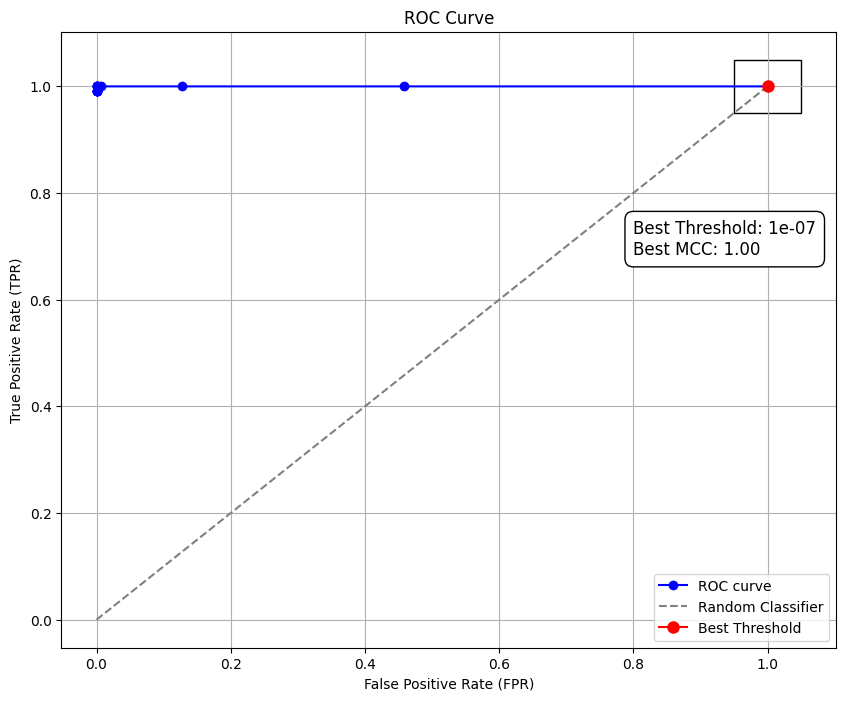

In [135]:
predicted_df = fold_set_1  
thresholds = [10**-i for i in range(-12, 12)]  
preds = get_data(predicted_df)  

#Initialize variables
best_threshold_1 = None
best_performance_metric = float('-inf')
mcc_dict = {}
FPR_values = []
TPR_values = []

#Write the result file
with open('train_set_1.res', 'w') as f:
    for threshold in thresholds:
        cm, predicted_labels, true_labels = calculate_cm(preds, threshold)
        accuracy, mcc, TPR, FPR, tp, fp, tn, fn = calculate_performance_metrics(cm)
        
        f.write("Threshold: %s\n" % threshold)
        f.write("Confusion Matrix:\n")
        f.write("%s\n" % cm)
        f.write("Accuracy: %s\n" % accuracy)
        f.write("Matthew Correlation Coefficient (MCC): %s\n" % mcc)
        f.write("True Positive Rate (TPR): %s\n" % TPR)
        f.write("False Positive Rate (FPR): %s\n\n" % FPR)
        
        #Update best threshold 
        if mcc > best_performance_metric:
            best_performance_metric = mcc
            best_threshold_1 = threshold
        
        
        mcc_dict[threshold] = mcc #Add MCC value to the dictionary with corresponding threshold
        TPR_values.append(TPR)
        FPR_values.append(FPR)

print("Best Threshold obtained during the training on fold 1: %s" % best_threshold_1)

#Filter the dictionary to include only the range of evalue thresholds
filtered_mcc_dict = {}

for key, value in mcc_dict.items():
    if key >= 10**-12 and key <= 10**-5:
        filtered_mcc_dict[key] = value


thresholds = []
mcc_values = []

for key in filtered_mcc_dict.keys():
    thresholds.append(key)
    mcc_values.append(filtered_mcc_dict[key])

#Find  best threshold in the  range
best_threshold = None
best_mcc = float('-inf')

for key in filtered_mcc_dict.keys():
    if filtered_mcc_dict[key] > best_mcc:
        best_mcc = filtered_mcc_dict[key]
        best_threshold = key

plot_roc_curve(FPR_values, TPR_values, best_threshold, best_mcc, save_path='roc_train_set_1.png')


In [136]:
best_threshold

1e-07

Accuracy: 0.9999949984245037
Matthew Correlation Coefficient (MCC): 0.9960213487064152
True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 5.004704422156827e-06


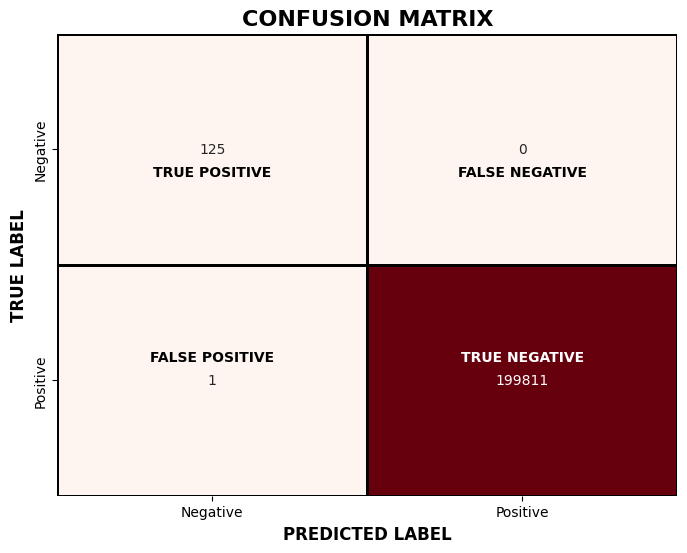

In [137]:
#### TEST ON FOLD 2 ###

import matplotlib.pyplot as plt
import seaborn as sns


predicted_df = fold_set_2
preds = get_data(predicted_df)  

cm, predicted_labels, true_labels = calculate_cm(preds, best_threshold)
accuracy, mcc, TPR, FPR, tp, fp, tn, fn = calculate_performance_metrics(cm)
plot_confusion_matrix(cm, save_path='cm_test_set_2.png')

print("Accuracy:", accuracy)
print("Matthew Correlation Coefficient (MCC):", mcc)
print("True Positive Rate (TPR):", TPR)
print("False Positive Rate (FPR):", FPR)

with open('test_set_2.res', 'w') as f:
    f.write("Confusion Matrix:\n")
    f.write("%s\n" % cm)
    f.write("Accuracy: %s\n" % accuracy)
    f.write("Matthew Correlation Coefficient (MCC): %s\n" % mcc)
    f.write("True Positive Rate (TPR): %s\n" % TPR)
    f.write("False Positive Rate (FPR): %s\n" % FPR)


## 8.2 Find the best threshold on fold 2 and test it on fold 1

Best Threshold obtained during the training on fold 2: 1e-08


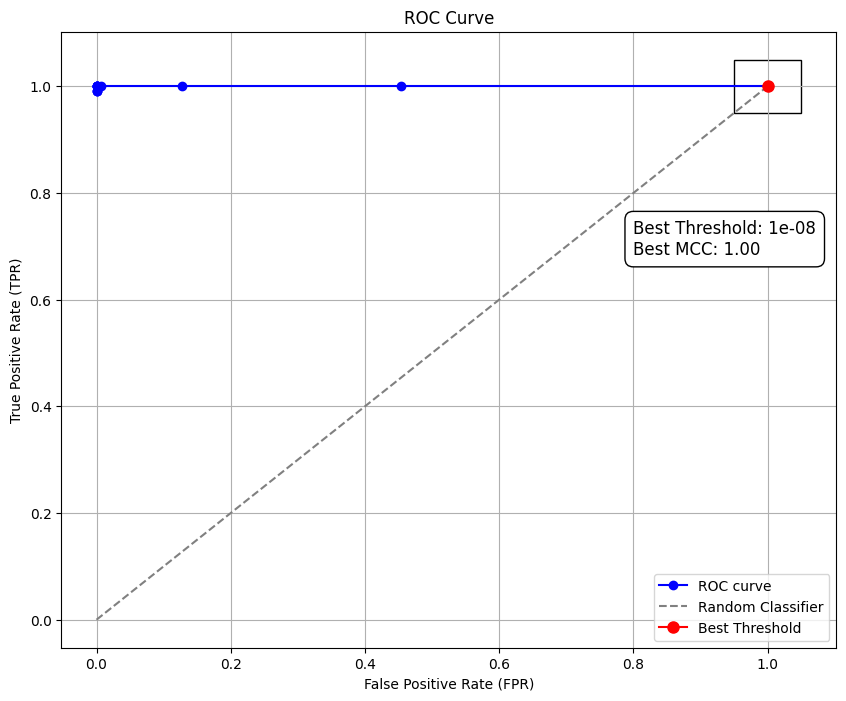

In [138]:
### TRAIN FOLD 2 ###

predicted_df_2 = fold_set_2 
thresholds_2 = [10**-i for i in range(-12, 12)]  
preds_2 = get_data(predicted_df_2)  # Pass the DataFrame object to the get_data function



best_threshold_2 = None
best_performance_metric_2 = float('-inf')
mcc_dict_2 = {}
TPR_values_2 = []
FPR_values_2 = []

with open('train_set_2.res', 'w') as f:
    for threshold in thresholds_2:
        cm, predicted_labels, true_labels = calculate_cm(preds, threshold)
        accuracy, mcc, TPR, FPR, tp, fp, tn, fn = calculate_performance_metrics(cm)
        TPR_values_2.append(TPR)
        FPR_values_2.append(FPR)   
        
        f.write("Threshold: %s\n" % threshold)
        f.write("Confusion Matrix:\n")
        f.write("%s\n" % cm)
        f.write("Accuracy: %s\n" % accuracy)
        f.write("Matthew Correlation Coefficient (MCC): %s\n" % mcc)
        f.write("True Positive Rate (TPR): %s\n" % TPR)
        f.write("False Positive Rate (FPR): %s\n\n" % FPR)
        

        if mcc > best_performance_metric_2:
            best_performance_metric_2 = mcc
            best_threshold_2 = threshold
        
        mcc_dict_2[threshold] = mcc

print("Best Threshold obtained during the training on fold 2:", best_threshold_2)

filtered_mcc_dict_2 = {}
for key, value in mcc_dict_2.items():
    if 10**-12 <= key <= 10**-5:
        filtered_mcc_dict_2[key] = value

thresholds_2 = list(filtered_mcc_dict_2.keys())
mcc_values_2 = list(filtered_mcc_dict.values())

best_threshold_2 = max(filtered_mcc_dict_2, key=filtered_mcc_dict_2.get)
best_mcc_2 = filtered_mcc_dict_2[best_threshold_2]

plot_roc_curve(FPR_values_2, TPR_values_2, best_threshold_2, best_mcc_2,save_path='roc_train_set_2.png')

In [139]:
best_threshold_2

1e-08

Accuracy: 0.9999949984495193
Matthew Correlation Coefficient (MCC): 0.9960213487188888
True Positive Rate (TPR): 0.9920634920634921
False Positive Rate (FPR): 0.0


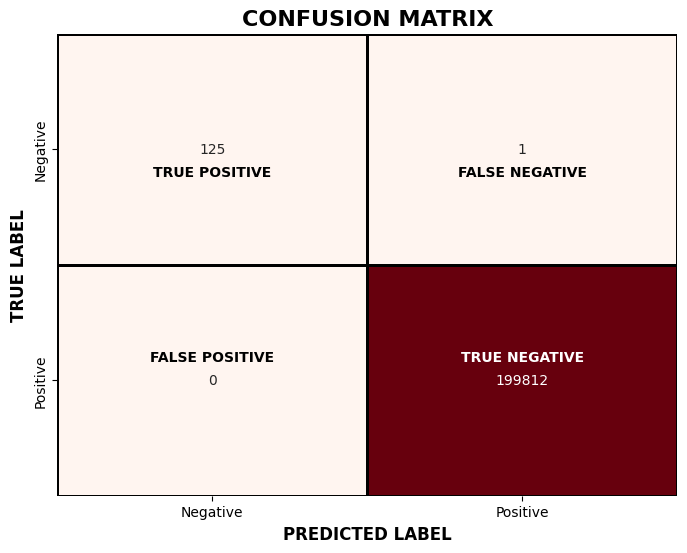

In [140]:
### TEST FOLD 1 ###

import matplotlib.pyplot as plt
import seaborn as sns

predicted_df = fold_set_1
preds = get_data(predicted_df)  

cm, predicted_labels, true_labels = calculate_cm(preds, best_threshold)
accuracy, mcc, TPR, FPR, tp, fp, tn, fn = calculate_performance_metrics(cm)
plot_confusion_matrix(cm, save_path='cm_test_set_1.png')


print("Accuracy:", accuracy)
print("Matthew Correlation Coefficient (MCC):", mcc)
print("True Positive Rate (TPR):", TPR)
print("False Positive Rate (FPR):", FPR)

with open('test_set_1.res', 'w') as f:
    f.write("Confusion Matrix:\n")
    f.write("%s\n" % cm)
    f.write("Accuracy: %s\n" % accuracy)
    f.write("Matthew Correlation Coefficient (MCC): %s\n" % mcc)
    f.write("True Positive Rate (TPR): %s\n" % TPR)
    f.write("False Positive Rate (FPR): %s\n" % FPR)


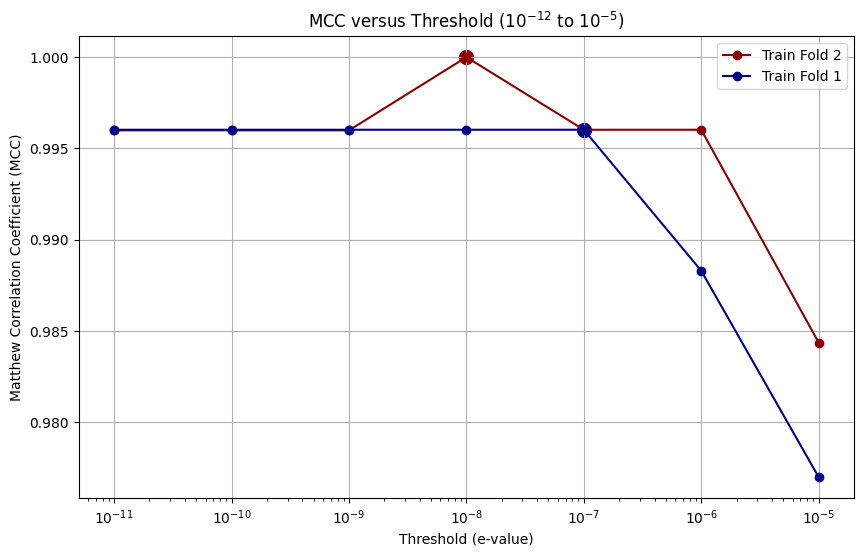

In [145]:
mcc_values_2 = list(filtered_mcc_dict_2.values())
thresholds_list = [thresholds, thresholds_2]
mcc_values_list = [mcc_values, mcc_values_2]  
best_thresholds_list = [best_threshold, best_threshold_2]
labels = ['Train Fold 1', 'Train Fold 2']

plot_mcc_vs_threshold(thresholds_list, mcc_values_list, best_thresholds_list, labels, "mcc_vs_threshold.png")


# 10. Average the thresholds and test on the test set (30%

In [142]:
print(best_threshold_1)
print(best_threshold_2)

1e-07
1e-08


In [143]:
av_th= (best_threshold_1 + best_threshold_2) / 2
av_th

5.4999999999999996e-08

Accuracy: 0.999994164809131
Matthew Correlation Coefficient (MCC): 0.9953566978564038
True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 5.838836436674899e-06

IDs of False Positive Proteins:
P56409

IDs of False Negative Proteins:


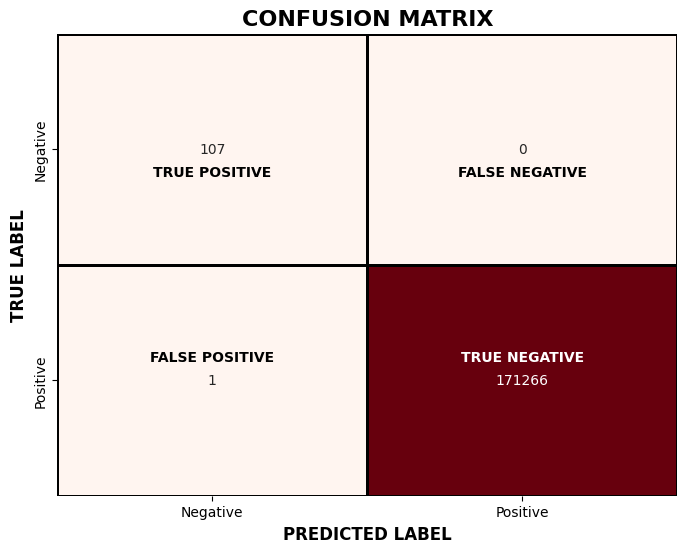

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predicted_df = test_df
preds = get_data(predicted_df)  # Pass the DataFrame object to the get_data function

cm, predicted_labels, true_labels = calculate_cm(preds, av_th)
accuracy, mcc, TPR, FPR, tp, fp, tn, fn = calculate_performance_metrics(cm)

plot_confusion_matrix(cm, save_path='cm_final_test_30%.png')

print("Accuracy: %s" % accuracy)
print("Matthew Correlation Coefficient (MCC): %s" % mcc)
print("True Positive Rate (TPR): %s" % TPR)
print("False Positive Rate (FPR): %s" % FPR)

with open('final_test_30%.res', 'w') as f:
    f.write("Confusion Matrix:\n")
    f.write("%s\n" % cm)
    f.write("Accuracy: %s\n" % accuracy)
    f.write("Matthew Correlation Coefficient (MCC): %s\n" % mcc)
    f.write("True Positive Rate (TPR): %s\n" % TPR)
    f.write("False Positive Rate (FPR): %s\n" % FPR)

#Find the IDs of false positive and false negatives
false_positive_ids = []
false_negative_ids = []

for i in range(len(preds)):
    protein_id = preds[i][0]
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]
    if predicted_label == 1 and true_label == 0:
        false_positive_ids.append(protein_id)
    elif predicted_label == 0 and true_label == 1:
        false_negative_ids.append(protein_id)

print("\nIDs of False Positive Proteins:")
for protein_id in false_positive_ids:
    print(protein_id)

print("\nIDs of False Negative Proteins:")
for protein_id in false_negative_ids:
    print(protein_id)
